In [1]:
from commonfunctions import *
from pre_processing import *
from staff import calculate_thickness_spacing, remove_staff_lines, coordinator
from segmenter import Segmenter
from connected_componentes import  *
from fit import predict
from box import Box
import glob
import cv2
import pickle
from imutils import resize as im_resize
from scipy.ndimage import binary_fill_holes
from skimage.morphology import skeletonize, thin

In [2]:
imgs_path = '//Users/daphnae/Downloads/Project-DIP/testcases/05.PNG'

In [3]:
label_map = {
    0:{
        0: 'N0'
    },
    1:{
        0:'b2',
        1:'a2'
    },
    2:{
        0:'g2',
        1:'f2'
    },
    3:{
        0:'e2',
        1:'d2'
    },
    4:{
        0:'c2',
        1:'b1'
    },
    5:{
        0:'a1',
        1:'g1'
    },
    6:{
        0:'f1',
        1:'e1'
    },
    7:{
        0:'d1',
        1:'c1'
    }
}

/Users/daphnae/Downloads/Project-DIP/commonfunctions.py:45: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  gray = rgb2gray(img)


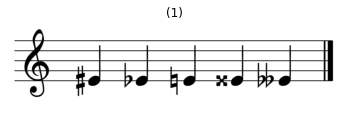

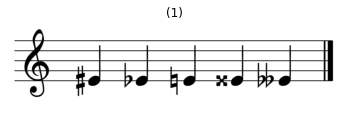

In [4]:
img = io.imread(f'{imgs_path}')
img = gray_img(img)
show_images([img])
horizontal = IsHorizontal(img)
if horizontal == False:
    theta = deskew(img)
    img = rotation(img,theta)
    img = get_gray(img)
    img = get_thresholded(img, threshold_otsu(img))
    img = get_closer(img)
    horizontal = IsHorizontal(img)
show_images([img])

(310, 1240)


/Users/daphnae/Downloads/Project-DIP/commonfunctions.py:63: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  gray = rgb2gray(np.copy(img))


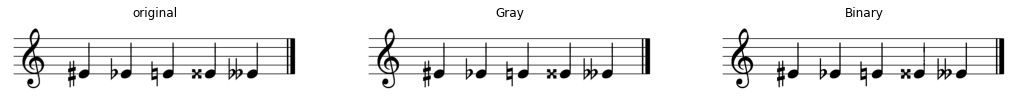

In [5]:

print(img.shape)
original = img.copy()
gray = get_gray(img)
bin_img = get_thresholded(gray, threshold_otsu(gray))
show_images([original,gray, bin_img], ['original','Gray', 'Binary'])

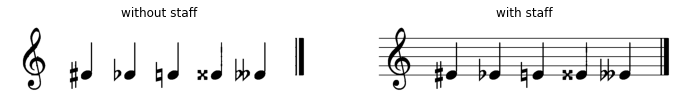

In [14]:
segmenter = Segmenter(bin_img)
imgs_with_staff = segmenter.regions_with_staff
imgs_without_staff = segmenter.regions_without_staff

for i, img in enumerate(imgs_without_staff):
    show_images([img, imgs_with_staff[i]],['without staff','with staff'])

In [18]:
imgs_spacing = []
imgs_rows = []
coord_imgs = []
for img in imgs_with_staff:
    spacing, rows, no_staff_img = coordinator(img,horizontal)
    imgs_rows.append(rows)
    imgs_spacing.append(spacing)
    coord_imgs.append(no_staff_img)
print('spacing:',imgs_spacing )
print ('Rows',imgs_rows )
print('coord:',coord_imgs )

spacing: [34]
Rows [[28.0, 65.0, 102.0, 139.0, 176.0, 213.0, 250.0]]
coord: [array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])]


In [19]:
def estim(c, idx):
    print('estim idx: ', idx)
    spacing = imgs_spacing[idx]
    rows = imgs_rows[idx]
    margin = 1+(spacing/4)
    for index,line in enumerate (rows):
        if c >= line - margin and c <= line + margin:
            return index+1, 0
        elif c >= line + margin and c <= line + 3*margin:
            return index+1, 1
    return 0 , 0 

28
65
102
139
176
213
250


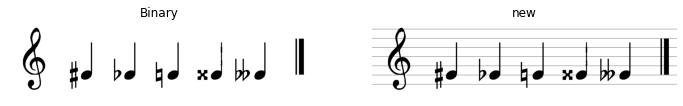

In [20]:
def draw_staff(img,row_positions):
    image = np.copy(img)
    for x in range (len(row_positions)):
        print(int(row_positions[x]))
        image[int(row_positions[x]),:] = 0
    return image

for i, img in enumerate(coord_imgs):
    new_img = draw_staff(img,imgs_rows[i])
    show_images([img,new_img], ['Binary','new'])  
    cv2.imwrite(f'_without_staff_{i}.png', np.array(255*img).astype(np.uint8))
    cv2.imwrite(f'_with_new_staff_{i}.png', np.array(255*new_img).astype(np.uint8))

In [21]:
def get_note_name(prev, octave, duration):
    if duration in ['4', 'a_4']:
        return f'{octave[0]}{prev}{octave[1]}/4'
    elif duration in ['8', '8_b_n', '8_b_r', 'a_8']:
        return f'{octave[0]}{prev}{octave[1]}/8'
    elif duration in ['16', '16_b_n', '16_b_r', 'a_16']:
        return f'{octave[0]}{prev}{octave[1]}/16'
    elif duration in ['32', '32_b_n', '32_b_r', 'a_32']:
        return f'{octave[0]}{prev}{octave[1]}/32'
    elif duration in ['2', 'a_2']:
        return f'{octave[0]}{prev}{octave[1]}/2'
    elif duration in ['1', 'a_1']:
        return f'{octave[0]}{prev}{octave[1]}/1'

In [22]:
def filter_beams(prims, prim_with_staff, bounds):
    n_bounds = []
    n_prims = []
    n_prim_with_staff = []
    for i, prim in enumerate(prims):
        if prim.shape[1] >= 2*prim.shape[0]:
            print('filter: ', prim.shape)
            continue
        else:
            n_bounds.append(bounds[i])
            n_prims.append(prims[i])
            n_prim_with_staff.append(prim_with_staff[i])
    return n_prims, n_prim_with_staff, n_bounds

In [24]:
def get_chord_notation(chord_list):
    chord_res = "{"
    for chord_note in chord_list:
        chord_res += f"{str(chord_note)},"
    chord_res = chord_res[:-1]
    chord_res += "}"

    return chord_res

1


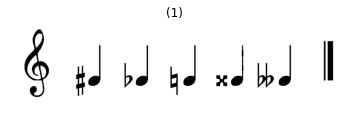

[(23, 65, 273, 156), (158, 256, 269, 288), (82, 301, 232, 346), (148, 435, 239, 465), (82, 477, 232, 522), (161, 605, 265, 632), (82, 653, 232, 698), (193, 775, 233, 815), (82, 829, 232, 875), (148, 928, 239, 988), (82, 1006, 232, 1051), (67, 1172, 212, 1179), (67, 1187, 212, 1207)]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


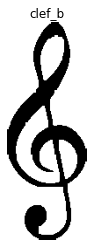

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


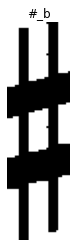

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


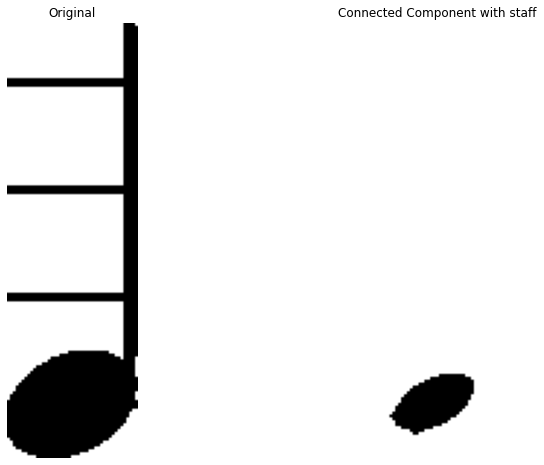

estim idx:  0
231.25
e1


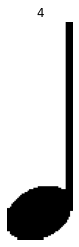

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


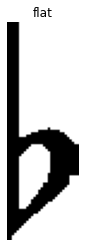

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


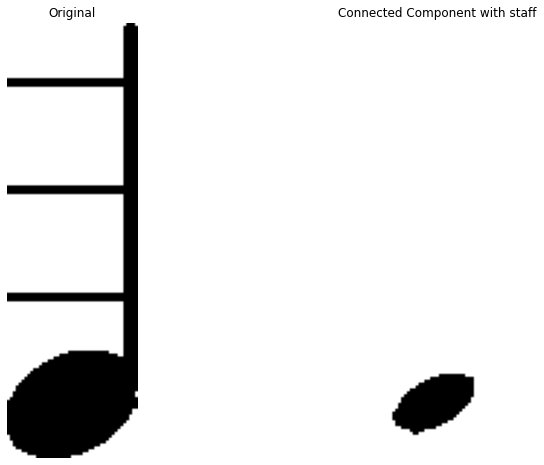

estim idx:  0
231.25
e1


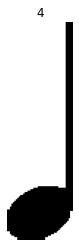

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


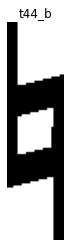

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


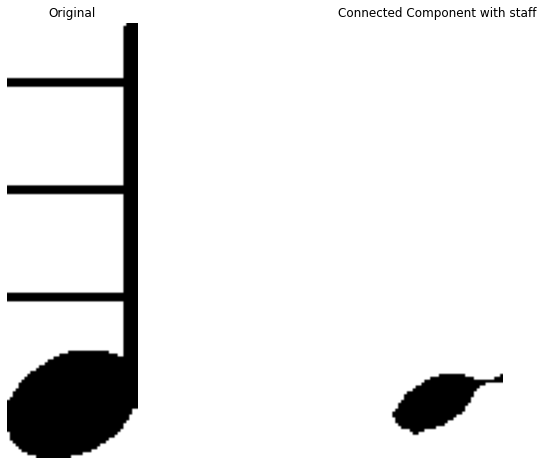

estim idx:  0
231.25
e1


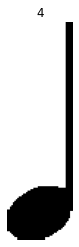

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


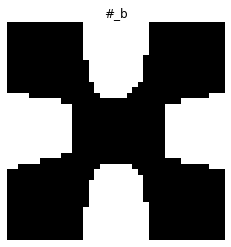

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


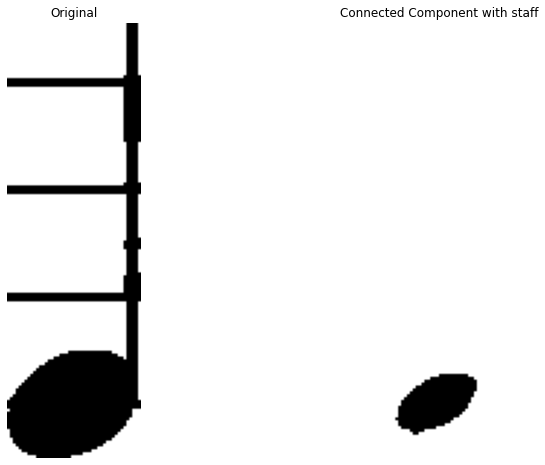

estim idx:  0
231.25
e1


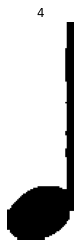

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


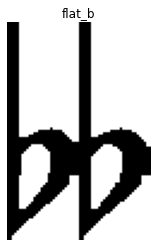

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


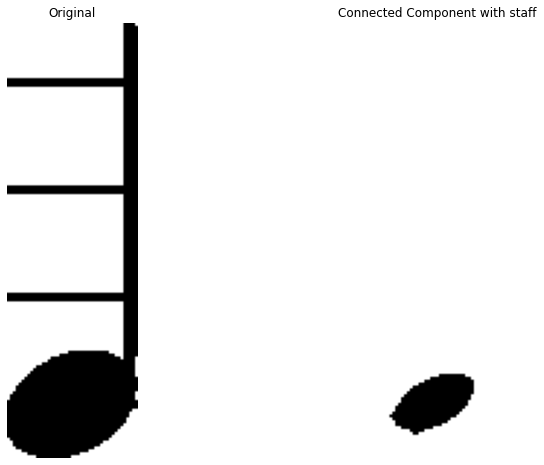

estim idx:  0
231.25
e1


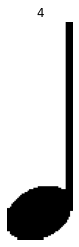

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


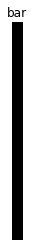

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


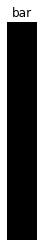

['e#1/4', 'e&1/4', 'e1/4', 'e##1/4', 'e&&1/4']


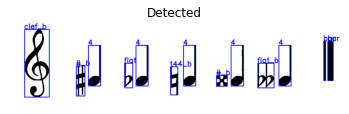

In [25]:
black_names = ['4', '8', '8_b_n', '8_b_r', '16', '16_b_n', '16_b_r', '32', '32_b_n', '32_b_r', 'a_4', 'a_8', 'a_16', 'a_32', 'chord']
ring_names = ['2', 'a_2']
whole_names = ['1', 'a_1']
disk_size = segmenter.most_common / 4
print(len(coord_imgs))
octave = None
for i, img in enumerate(coord_imgs):
    show_images([img])
    res = []
    prev = ''
    time_name = ''
    primitives, prim_with_staff, boundary = get_connected_components(img, imgs_with_staff[i])
    print(boundary)
    detected = cv2.cvtColor(np.array(255*img.copy()).astype(np.uint8),cv2.COLOR_GRAY2RGB)
    for j, prim in enumerate(primitives):
        minr, minc, maxr, maxc = boundary[j]

        prim = binary_opening(prim, square(segmenter.most_common-imgs_spacing[i]))
        saved_img = (255*(1 - prim)).astype(np.uint8)
        labels = predict(saved_img)
        label = labels[0]

        cv2.rectangle(detected, (minc, minr), (maxc, maxr), (0, 0, 255), 2)
        cv2.putText(detected, label, (minc-2, minr-2), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

        if label in black_names:
            test_img = np.copy(prim_with_staff[j])
            test_img = binary_dilation(test_img, disk(disk_size))
            show_images([prim_with_staff[j], test_img], ['Original', 'Connected Component with staff'])
            comps, comp_w_staff, bounds = get_connected_components(test_img, prim_with_staff[j])
            comps, comp_w_staff, bounds = filter_beams(comps, comp_w_staff, bounds)
            bounds = [np.array(bound)+disk_size-2 for bound in bounds]

            if len(bounds) > 1 and label not in ['8_b_n', '8_b_r', '16_b_n', '16_b_r', '32_b_n', '32_b_r']:
                l_res = []
                bounds = sorted(bounds, key= lambda b : -b[2])
                for k in range(len(bounds)):
                    print("Bound")
                    idx, p = estim(boundary[j][0]+bounds[k][2], i)
                    l_res.append(f'{label_map[idx][p]}/4')
                    if k+1 < len(bounds) and (bounds[k][2]-bounds[k+1][2]) > 1.5*imgs_spacing[i]:
                        print("IF COND", bounds[k][2]-bounds[k+1][2], 1.25*imgs_spacing[i])
                        idx, p = estim(boundary[j][0]+bounds[k][2]-imgs_spacing[i]/2, i)
                        l_res.append(f'{label_map[idx][p]}/4')
                res.append(sorted(l_res))
            else:
                for bbox in bounds:
                    c = bbox[2]+boundary[j][0]
                    line_idx, p = estim(int(c), i)
                    l = label_map[line_idx][p]
                    res.append(get_note_name(prev, l, label))
                    print(c)
                    print(l)
        elif label in ring_names:
            head_img = 1-binary_fill_holes(1-prim)
            head_img = binary_closing(head_img, disk(disk_size))
            comps, comp_w_staff, bounds = get_connected_components(head_img, prim_with_staff[j])
            for bbox in bounds:
                c = bbox[2]+boundary[j][0]
                line_idx, p = estim(int(c), i)
                l = label_map[line_idx][p]
                res.append(get_note_name(prev, l, label))
                print(c)
                print(l)
        elif label in whole_names:
            c = boundary[j][2]
            line_idx, p = estim(int(c), i)
            l = label_map[line_idx][p]
            res.append(get_note_name(prev, l, label))
            print(c)
            print(l)
        elif label in ['bar', 'bar_b', 'clef', 'clef_b', 'natural', 'natural_b']:
            show_images([prim], [label])
            continue
        elif label in ['#', '#_b']:
            prev = '##' if prim.shape[0] == prim.shape [1] else '#'
        elif label in ['cross']:
            prev = '##'
        elif label in ['flat', 'flat_b']:
            prev = '&&' if prim.shape[1] >= 0.5*prim.shape[0] else '&'
        elif label in ['dot', 'dot_b', 'p', 't24_b']:
            if len(res) == 0 or (len(res) > 0 and res[-1] in ['flat', 'flat_b', 'cross', '#', '#_b', 't24', 't24_b', 't44', 't44_b']):
                continue
            res[-1] += '.'
        elif label in ['t2', 't4']:
            time_name += label[1]
        elif label == 'chord':
            print('Chord')
            img = thin(1-prim.copy(), max_iter=20)
            head_img = binary_closing(1-img, disk(disk_size))
        if label not in ['flat', 'flat_b', 'cross', '#', '#_b']:
            prev = ''
        show_images([prim], [label])
        if len(time_name) == 2:
            res = ["\\" + "meter<\"" + str(time_name[0]) + "/" + str(time_name[1])+"\">"] + res
    print(res)
    show_images([detected], ['Detected'])
    cv2.imwrite(f'_detected_{i}.png', detected)